# 【問題1】スクラッチを振り返る

ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。


（例）

重みを初期化する必要があった

エポックのループが必要だった

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。



# ➡︎
* #### 誤差逆伝播を行ってパラメータを探索する必要があった
* #### 更新式によってパラメータを更新する必要があった

# データセットの用意

以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。


Iris Species


目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。


Iris-versicolor
Iris-virginica

# 【問題2】スクラッチとTensorFlowの対応を考える

以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。


それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。


《サンプルコード》


＊バージョン1.5から1.14の間で動作を確認済みです。



In [1]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# データセットの読み込み
dataset_path =("/Users/nobu/Documents/データセット/datasets_19_420_Iris.csv")
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
#versicolor",virginicaのデータだけ抜き出す
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]

#目的変数と特徴量に分ける
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]

#ndarray化
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
#データ型指定
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)




class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    
    
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]#4
n_samples = X_train.shape[0]#64
n_classes = 1
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)




def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output



# ネットワーク構造の読み込み                               
logits = example_net(X)#最終層からの出力

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))#label(実測値)logits(推定値)

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
#tf.equal(引数に指定された二つの値が等しいかどうかboolで返す)
#tf.sign(引数の値が正なら1,負なら0)

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()




# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)#初期化
    
    # エポックごとにループ
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)#データ数÷バッチサイズ（np.ceilで繰り上げ）
        total_loss = 0
        total_acc = 0
        
        # ミニバッチごとにループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        
        #エポックごとにlossとaccを算出
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 0, loss : 10.5244, val_loss : 8.1074, acc : 0.250, val_acc : 0.625
Epoch 1, loss : 2.8118, val_loss : 6.7625, acc : 0.750, val_acc : 0.438
Epoch 2, loss : 2.7360, val_loss : 6.1765, acc : 0.750, val_acc : 0.625
Epoch 3, loss : 0.0235, val_loss : 1.7943, acc : 1.000, val_acc : 0.688
Epoch 4, loss : 0.5898, val_loss : 3.7921, acc : 0.750, val_acc : 0.750
Epoch 5, loss : 0.4287, val_loss : 3.8861, acc : 0.750, val_acc : 0.625
Epoch 6, loss : 1.4522, val_loss : 4.5499, acc : 0.750, val_acc : 0.688
Epoch 7, loss : 2.4054, val_loss : 7.4403, acc : 0.750, val_acc : 0.500
Epoch 8, loss : 0.0443, val_loss : 3.1684, acc : 1.000, val_acc : 0.812
Epoch 9, loss : 0.0001, val_loss : 1.8659, acc : 1.000, val_acc : 0.812
test_acc : 0.700


# ➡︎
* 初期化手法 

global_variables_initializer()で初期化を行っている

* パラメータの更新

最適化手法をoptimizerで指定してパラメータを更新している

パラメータをtf.Valiableとして扱う

# 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成
Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類全てを分類できるモデルを作成してください。


Iris Species


2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。


《ヒント》


以下の2箇所は2クラス分類特有の処理です。


```python
loss_op=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
```

Epoch 0, loss : 0.5797, val_loss : 1.1718, acc : 0.667, val_acc : 0.583
Epoch 1, loss : 0.2740, val_loss : 0.7768, acc : 0.833, val_acc : 0.625
Epoch 2, loss : 0.1140, val_loss : 0.3251, acc : 1.000, val_acc : 0.792
Epoch 3, loss : 0.0970, val_loss : 0.2430, acc : 1.000, val_acc : 0.917
Epoch 4, loss : 0.0943, val_loss : 0.2509, acc : 1.000, val_acc : 0.917
Epoch 5, loss : 0.0575, val_loss : 0.2221, acc : 1.000, val_acc : 0.917
Epoch 6, loss : 0.0356, val_loss : 0.2002, acc : 1.000, val_acc : 0.917
Epoch 7, loss : 0.0248, val_loss : 0.1914, acc : 1.000, val_acc : 0.917
Epoch 8, loss : 0.0188, val_loss : 0.1888, acc : 1.000, val_acc : 0.917
Epoch 9, loss : 0.0148, val_loss : 0.1896, acc : 1.000, val_acc : 0.917
test_acc : 0.967


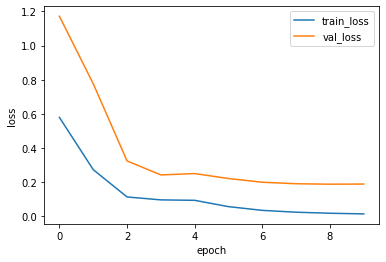

In [17]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを3値分類する
"""
# データセットの読み込み
dataset_path =("/Users/nobu/Documents/データセット/datasets_19_420_Iris.csv")
df = pd.read_csv(dataset_path)

#特徴量を抽出
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
X = np.array(X)

# ラベルをonehot化
y = np.array(pd.get_dummies(df["Species"]))
#データ型を変換
y = y.astype(np.int)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)



tf.reset_default_graph()

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3#ラベルの種類分出力

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)


def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.get_variable(name='W1',shape=[n_input, n_hidden1],initializer=tf.initializers.he_normal()),
        'w2': tf.get_variable(name='W2',shape=[n_hidden1, n_hidden2],initializer=tf.initializers.he_normal()),
        'w3': tf.get_variable(name='W3',shape=[n_hidden2, n_classes],initializer=tf.initializers.he_normal())
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である

    
    return layer_output




# ネットワーク構造の読み込み                               
logits = example_net(X)#softmaxからの出力

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))#label(実測値)logits(推定値)
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y,axis=1), tf.argmax(logits,axis=1))#softmaxを通して推定した中で各データにおける一番確率の高いインデックスを返す

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init =tf.global_variables_initializer()


#学習曲線描画のためにl損失を保存するリスト
loss_lst = []
val_loss_lst = []

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)#初期化
    
    # エポックごとにループ
    for epoch in range(num_epochs): 
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)#データ数÷バッチサイズ（np.ceilで繰り上げ）
        total_loss = 0
        total_acc = 0
        
        # ミニバッチごとにループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        
        #エポックごとに損失を記録    
        loss_lst.append(loss)
        val_loss_lst.append(val_loss)
    
    #最後に取っておいたテストデータで検証
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))


#グラフ描画
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_lst, label=("train_loss"))
plt.plot(val_loss_lst, label=("val_loss"))
plt.legend()

# 【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。


House Prices: Advanced Regression Techniques


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。


分類問題と回帰問題の違いを考慮してください。
## ➡︎
* 対数変換＆標準化を行った
* n_classes(出力数)を１にした
* 最後の層からの出力をsoftmax使わずそのまま流した（恒等関数使う意味とは？）
* 目的関数で最小２乗法を使った
* 指標値計算に平均２乗誤差を使った


Epoch 0, loss : 0.0169, val_loss : 0.0534, mse : 0.034, val_mse : 0.107
Epoch 1, loss : 0.0047, val_loss : 0.0238, mse : 0.009, val_mse : 0.048
Epoch 2, loss : 0.0052, val_loss : 0.0231, mse : 0.010, val_mse : 0.046
Epoch 3, loss : 0.0048, val_loss : 0.0222, mse : 0.010, val_mse : 0.044
Epoch 4, loss : 0.0068, val_loss : 0.0217, mse : 0.014, val_mse : 0.043
Epoch 5, loss : 0.0065, val_loss : 0.0219, mse : 0.013, val_mse : 0.044
Epoch 6, loss : 0.0038, val_loss : 0.0227, mse : 0.008, val_mse : 0.045
Epoch 7, loss : 0.0038, val_loss : 0.0247, mse : 0.008, val_mse : 0.049
Epoch 8, loss : 0.0037, val_loss : 0.0269, mse : 0.007, val_mse : 0.054
Epoch 9, loss : 0.0035, val_loss : 0.0260, mse : 0.007, val_mse : 0.052
test_mse : 0.050


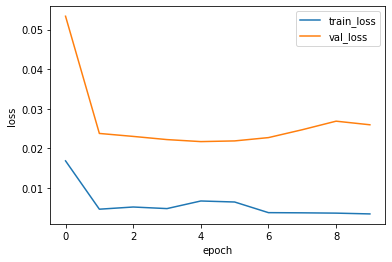

In [21]:
# データセットの読み込み
df = pd.read_csv("/Users/nobu/Documents/データセット/house-prices-advanced-regression-techniques/train.csv")




#データセット
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea","YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]

#対数変換
y = np.log(y)
X = np.log(X)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#特徴量を標準化
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)
X_val = std.transform(X_val)

tf.reset_default_graph()

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 100
n_hidden2 = 50
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1#回帰なので１

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)




def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.get_variable(name='W1',shape=[n_input, n_hidden1],initializer=tf.initializers.he_normal()),
        'w2': tf.get_variable(name='W2',shape=[n_hidden1, n_hidden2],initializer=tf.initializers.he_normal()),
        'w3': tf.get_variable(name='W3',shape=[n_hidden2, n_classes],initializer=tf.initializers.he_normal())
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    #回帰は流れてきた値をそのまま出力する
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である

    return layer_output





# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数（最小２乗法）
loss_op = tf.reduce_mean(tf.squared_difference(logits,Y))*0.5#logits(推定値)Y(実測値)

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = logits

# 指標値計算(平均２乗誤差MSE)
MSE = tf.reduce_mean(tf.squared_difference(correct_pred,Y))

# variableの初期化
init =tf.global_variables_initializer()

#学習曲線描画のためにl損失を保存するリスト
loss_lst = []
val_loss_lst = []

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)#初期化
    
    # エポックごとにループ
    for epoch in range(num_epochs):
        
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)#データ数÷バッチサイズ（np.ceilで繰り上げ）
        total_loss = 0
        total_mse = 0
        
        # ミニバッチごとにループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train): 
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            
            #変数名がかぶるので計算を行うMSE、計算した値を保持するmseで区別する
            loss, mse = sess.run([loss_op, MSE], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_mse += mse
        total_loss /= n_samples
        total_mse /= n_samples
        
        val_loss, val_mse = sess.run([loss_op, MSE], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, mse : {:.3f}, val_mse : {:.3f}".format(epoch, loss, val_loss, mse, val_mse))
        #エポックごとに損失を記録    
        loss_lst.append(loss)
        val_loss_lst.append(val_loss)
    #最後に取っておいたテストデータで検証
    test_mse = sess.run(MSE, feed_dict={X: X_test, Y: y_test})
    print("test_mse : {:.3f}".format(test_mse))


    

#グラフ描画
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_lst, label=("train_loss"))
plt.plot(val_loss_lst, label=("val_loss"))
plt.legend()

 # 【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。


3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。


スクラッチで実装したモデルの再現を目指してください。

In [2]:
"""
TensorFlowで実装したニューラルネットワークを使いMNISTデータセットを１０値分類する
"""
# データセットの読み込み
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#特徴量の前処理
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#目的変数の前処理（ワンホット化）
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

tf.reset_default_graph()
# ハイパーパラメータの設定
learning_rate = 0.0001
batch_size = 10
num_epochs = 10
n_hidden1 = 400
n_hidden2 = 200
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10#ラベルの種類分出力

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)




def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.get_variable(name='W1',shape=[n_input, n_hidden1],initializer=tf.initializers.he_normal()),
        'w2': tf.get_variable(name='W2',shape=[n_hidden1, n_hidden2],initializer=tf.initializers.he_normal()),
        'w3': tf.get_variable(name='W3',shape=[n_hidden2, n_classes],initializer=tf.initializers.he_normal())
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    
    return layer_output






# ネットワーク構造の読み込み                               
logits = example_net(X)#softmaxからの出力

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))#label(実測値)logits(推定値)

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y,axis=1), tf.argmax(logits,axis=1))#softmaxを通して推定した中で一番確率の高いインデックスを返す

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init =tf.global_variables_initializer()


#学習曲線描画のためにl損失を保存するリスト
loss_lst = []
val_loss_lst = []




Epoch 0, loss : 0.0476, val_loss : 0.1993, acc : 1.000, val_acc : 0.942
Epoch 1, loss : 0.0289, val_loss : 0.1393, acc : 1.000, val_acc : 0.959
Epoch 2, loss : 0.0230, val_loss : 0.1154, acc : 1.000, val_acc : 0.966
Epoch 3, loss : 0.0154, val_loss : 0.1023, acc : 1.000, val_acc : 0.970
Epoch 4, loss : 0.0095, val_loss : 0.0953, acc : 1.000, val_acc : 0.972
Epoch 5, loss : 0.0075, val_loss : 0.0910, acc : 1.000, val_acc : 0.973
Epoch 6, loss : 0.0047, val_loss : 0.0889, acc : 1.000, val_acc : 0.974
Epoch 7, loss : 0.0043, val_loss : 0.0897, acc : 1.000, val_acc : 0.974
Epoch 8, loss : 0.0025, val_loss : 0.0908, acc : 1.000, val_acc : 0.976
Epoch 9, loss : 0.0013, val_loss : 0.0939, acc : 1.000, val_acc : 0.976
test_acc : 0.978
CPU times: user 3min 2s, sys: 25.3 s, total: 3min 27s
Wall time: 1min 24s


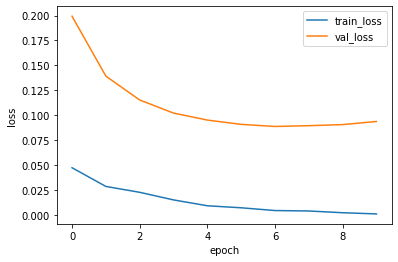

In [3]:
%%time
# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)#初期化
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)#データ数÷バッチサイズ（np.ceilで繰り上げ）
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        
        #エポックごとに損失を記録
        loss_lst.append(loss)
        val_loss_lst.append(val_loss)
        
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))


    
#グラフ描画
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_lst, label=("train_loss"))
plt.plot(val_loss_lst, label=("val_loss"))
plt.legend()

➡︎

全体的に過学習していた。 NNの過学習を抑えるには正則化やDropout、Batch Normalizationが有効とのこと